# Multimodal structured data extraction

## Overview
Manual data extraction from invoices is time-consuming and error-prone, especially when dealing with multiple documents in different formats. Cohere's Command Vision with Structured Outputs provides a solution by automatically extracting structured data from invoice images using AI vision capabilities.

This notebook demonstrates how to extract structured information from invoice images using Cohere's Command Vision model based on a JSON schema. The automated invoice data extraction pipeline converts visual documents into structured, tabular data ready for analysis.

## Contents
- Converting images to base64
- Defining JSON schema for extraction  
- Prompting Command Vision with structured outputs
- Collating information from multiple invoices

## Setup

In [1]:
# %pip install -U cohere pdf2image pillow

In [1]:
from PIL import Image
from io import BytesIO
import base64

In [ ]:
import cohere
import os
co = cohere.ClientV2(os.getenv("COHERE_API_KEY"), log_warning_experimental_features=False) 

model = "command-a-vision-07-2025"

In [3]:
data_path = "data/extraction"

## Specify the image paths

We'll be using invoices data from [Hugging Face](https://huggingface.co/datasets/katanaml-org/invoices-donut-data-v1).

In [4]:
# Dataset source: https://huggingface.co/datasets/katanaml-org/invoices-donut-data-v1

images_path = [
    os.path.join(data_path, f)
    for f in os.listdir(data_path)
    if f.endswith((".png", ".jpg", ".jpeg"))
]
len(images_path)

3

## Convert images to base64

In [5]:
def images_to_base64(images_path):
    """Accepts a list of image file paths and returns a list of dicts with filename and base64 data URL."""

    images = []
    for image_path in images_path:
        with Image.open(image_path) as img:
            image_format = img.format.lower()
            buffered = BytesIO()
            img.save(buffered, format=img.format)
            img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
        data_url = f"data:image/{image_format};base64,{img_base64}"
        filename = image_path.split("/")[-1]
        images.append({
            'text': filename,
            'path': image_path,
            'image_url': data_url
        })
    return images

images_base64 = images_to_base64(images_path)

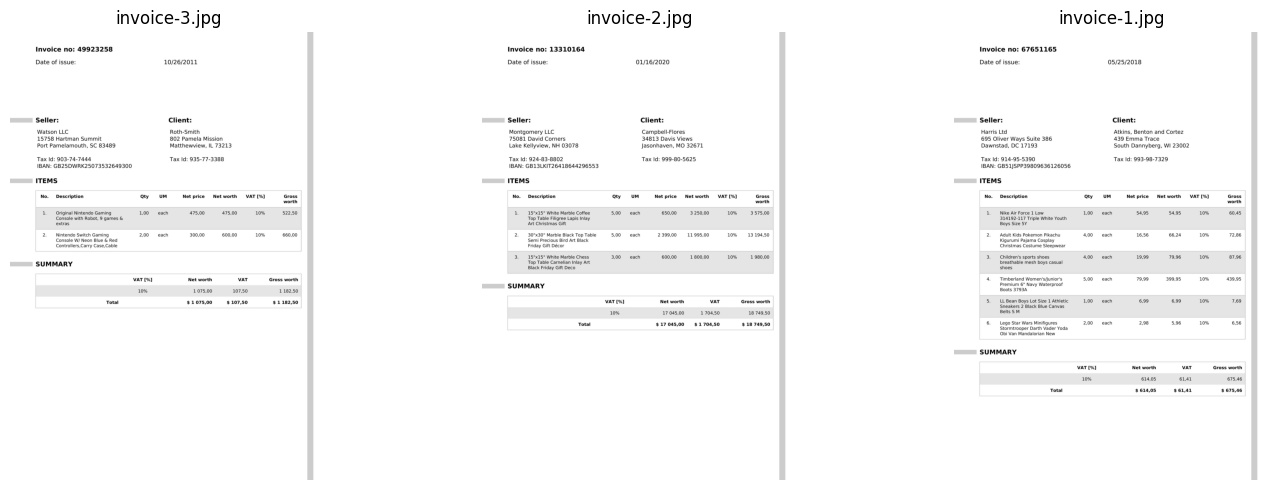

In [6]:
# Display first three images in the same row
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    if i < len(images_path):
        img = plt.imread(images_path[i])
        ax.imshow(img)
        filename = images_path[i].split("/")[-1]
        ax.set_title(filename)
        ax.axis('off')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()


## Define JSON schema for extraction

In [7]:
response_format = {
    "type": "json_object",
    "schema": {
        "type": "object",
        "properties": {
            "invoice_no": {"type": "string"},
            "date_of_issue": {"type": "string", "format": "date"},
            "seller": {
                "type": "object",
                "properties": {
                    "name": {"type": "string"},
                    "address": {"type": "string"},
                    "tax_id": {"type": "string"},
                    "iban": {"type": "string"},
                },
                "required": ["name", "address", "tax_id", "iban"],
            },
            "client": {
                "type": "object",
                "properties": {
                    "name": {"type": "string"},
                    "address": {"type": "string"},
                    "tax_id": {"type": "string"},
                },
                "required": ["name", "address", "tax_id"],
            },
            "items": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "no": {"type": "integer"},
                        "description": {"type": "string"},
                        "qty": {"type": "number"},
                        "um": {"type": "string"},
                        "net_price": {"type": "number"},
                        "net_worth": {"type": "number"},
                        "vat_percentage": {"type": "string"},
                        "gross_worth": {"type": "number"},
                    },
                    "required": [
                        "no",
                        "description",
                        "qty",
                        "um",
                        "net_price",
                        "net_worth",
                        "vat_percentage",
                        "gross_worth",
                    ],
                },
            },
            "summary": {
                "type": "object",
                "properties": {
                    "vat_percentage_overall": {"type": "string"},
                    "total_net_worth": {"type": "number"},
                    "total_vat": {"type": "number"},
                    "total_gross_worth": {"type": "number"},
                },
                "required": [
                    "vat_percentage_overall",
                    "total_net_worth",
                    "total_vat",
                    "total_gross_worth",
                ],
            },
        },
        "required": [
            "invoice_no",
            "date_of_issue",
            "seller",
            "client",
            "items",
            "summary",
        ],
    },
}

## Prompt Command Vision using the Structured Outputs feature

In [8]:
invoices_extracted = []

for invoice in images_base64:
    response = co.chat(
        model=model,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Please extract the information from this invoice following the schema provided."},
                    {"type": "image_url", "image_url": {"url": invoice["image_url"]}},
                ],
            }
        ],
        response_format=response_format,
    )

    invoices_extracted.append(response.message.content[0].text)

In [11]:
# Example from one invoice

invoices_extracted[0]

'{\n  "invoice_no": "49923258",\n  "date_of_issue": "1026-11-20",\n  "seller": {\n    "name": "Watson LLC",\n    "address": "15758 Hartman Summit, Port Pamelaouth, SC 83489",\n    "tax_id": "903-74-7444",\n    "iban": "GB25DWRK25073532649300"\n  },\n  "client": {\n    "name": "Roth-Smith",\n    "address": "802 Pamela Mission, Matthewview, IL 73213",\n    "tax_id": "935-77-3388"\n  },\n  "items": [\n    {\n      "no": 1,\n      "description": "Original Nintendo Gaming Console with Robot, 9 games & extras",\n      "qty": 1,\n      "um": "each",\n      "net_price": 475,\n      "net_worth": 475,\n      "vat_percentage":  "10%",\n      "gross_worth": 522.5\n    },\n    {\n      "no": 2,\n      "description": "Nintendo Switch Gaming Console W/ Neon Blue & Red Controllers,Carry Case,Cable",\n      "qty": 2,\n      "um": "each",\n      "net_price": 300,\n      "net_worth": 600,\n      "vat_percentage":  "10%",\n      "gross_worth": 660\n    }\n  ],\n  "summary": {\n    "vat_percentage_overall"

## Collate information from all invoices in a table 

In [12]:
import pandas as pd
import json # Import the json module

def invoices_to_table(invoice_data_list):
    processed_data = []
    for invoice_str in invoice_data_list: # Rename to invoice_str to reflect it's a string
        invoice = json.loads(invoice_str) # Parse the JSON string into a dictionary
        seller_name = invoice.get("seller", {}).get("name")
        client_name = invoice.get("client", {}).get("name")
        
        for item in invoice.get("items", []):
            row_data = {
                "seller_name": seller_name,
                "client_name": client_name,
                "item_description": item.get("description"),
                "item_qty": item.get("qty"),
                "item_um": item.get("um"),
                "item_net_price": item.get("net_price"),
                "item_net_worth": item.get("net_worth"),
                "vat_percentage": item.get("vat_percentage"),
                "gross_worth": item.get("gross_worth"),
            }
            processed_data.append(row_data)
            
    df = pd.DataFrame(processed_data)
    return df

# invoices_to_table(invoices_extracted) # I'll comment this out for now, as I don't have invoices_extracted

invoices_to_table(invoices_extracted)

,seller_name,client_name,item_description,item_qty,item_um,item_net_price,item_net_worth,vat_percentage,gross_worth
0,Watson LLC,Roth-Smith,"Original Nintendo Gaming Console with Robot, 9...",1,each,475.00,475.00,10%,522.50
1,Watson LLC,Roth-Smith,Nintendo Switch Gaming Console W/ Neon Blue & ...,2,each,300.00,600.00,10%,660.00
2,Montgomery LLC,Campbell-Flores,"15""x15"" White Marble Coffee Top Table Filigree...",5,each,650.00,3250.00,10%,3575.00
3,Montgomery LLC,Campbell-Flores,"30""x30"" Marble Black Top Table Semi Precious B...",5,each,2399.00,11995.00,10%,13194.50
4,Montgomery LLC,Campbell-Flores,"15""x15"" White Marble Chess Top Table Carnelian...",3,each,600.00,1800.00,10%,1980.00
5,Harris Ltd,"Atkins, Benton and Cortez",Nike Air Force 1 Low 314192-117 Triple White Y...,1,each,54.95,54.95,10%,60.45
6,Harris Ltd,"Atkins, Benton and Cortez",Adult Kids Pokemon Pikachu Kigurumi Pajama Cos...,4,each,16.56,66.24,10%,72.86
7,Harris Ltd,"Atkins, Benton and Cortez",Children's sports shoes breathable mesh boys c...,4,each,19.99,79.96,10%,87.96
8,Harris Ltd,"Atkins, Benton and Cortez","Timberland Women's/Juniors Premium 6"" Navy Wat...",5,each,79.99,399.95,10%,439.95
9,Harris Ltd,"Atkins, Benton and Cortez",LL Bean Boys Lot Size 1 Athletic Sneakers 2 Bl...,1,each,6.99,6.99,10%,7.69


## Conclusion
This notebook covered automated extraction of structured data from invoice images using Cohere's Command Vision model, demonstrating how to transform unstructured visual documents into organized, queryable data formats through JSON schema specification.